# Data Browser

View sample images, labels, and summary statistics from datasets 

In [1]:
from dataloaders import make_dataset
from dataloaders import custom_transforms as tr
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

from types import SimpleNamespace

### Set these variables as desired to load different datasets.

In [2]:
dataset_name = 'sunrgbd'

#All figures will be saved with the following prefix
figure_prefix = "figures/sunrgbd_"

# Dataset directory root
root = 'datasets/sunrgbd/'

# Default configuration file
cfg_file = 'configs/sunrgbd.yaml'

# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.GT_MODE', 'gtFine',
            'DATASET.CITYSCAPES.TRAIN_SET', 'train']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [3]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 8))
    
#     m = math.ceil(n/4)
    for ii in range(n):
        if images[ii] is not None:
            plt.subplot(1, n, ii+1)
            plt.imshow(images[ii])
            plt.title(labels[ii])
            plt.axis('off')

In [4]:
def display_labels(colors, names):
    # for i = range(10)
    fig = plt.figure(figsize=(5, 5))
    plt.subplots_adjust( wspace = 10 )
    col = max(int(len(names)/10), 1)
    for i in range(col):
        ax = plt.subplot(1,col,i+1)
        end = min(len(names), (i+1)*10)
        plt.imshow(colors[:, i*10:end, :].transpose((1,0,2)))
        plt.yticks(range(10), names[i*10:end])
        ax.get_xaxis().set_visible(False)

    fig.savefig(figure_prefix + 'segmentation_legend.eps', format='eps', dpi=300)
    

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Using RGB-D input
tensor([6166])
tensor([6167])
tensor([6168])
tensor([6169])
tensor([6170])


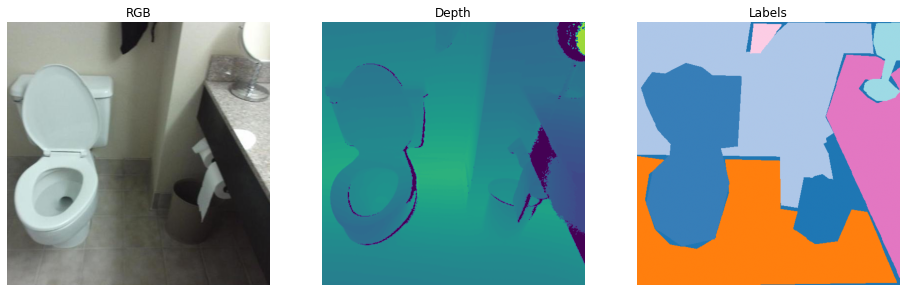

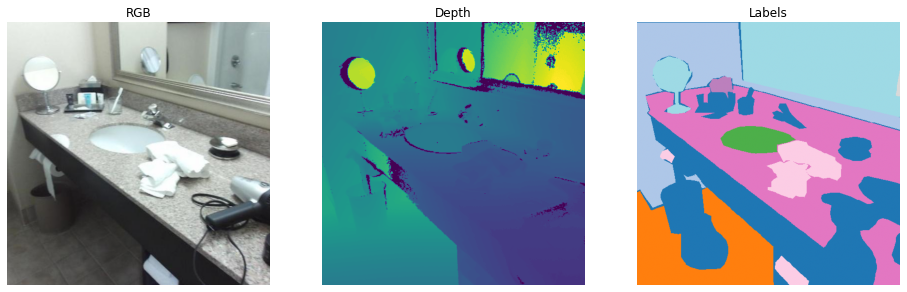

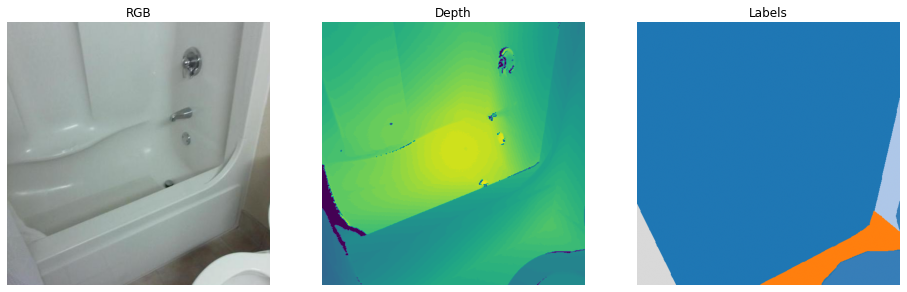

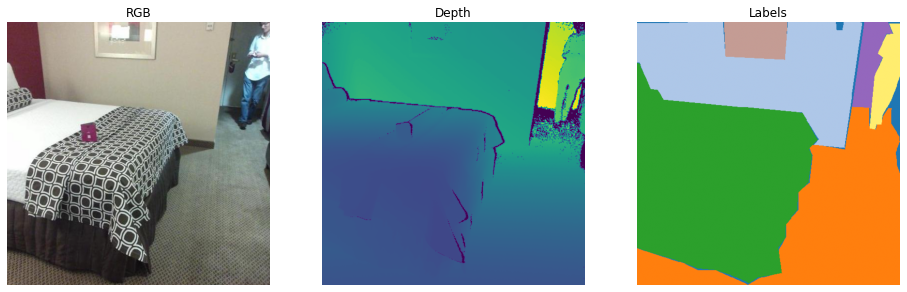

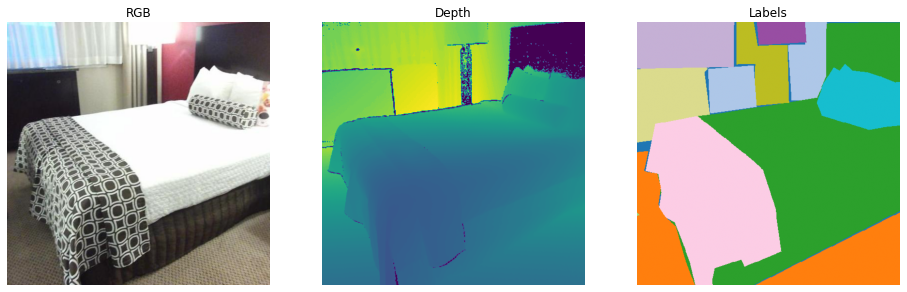

In [5]:
#Same as main method of dataloaders.datasets.coco
val = make_dataset(cfg, split='val')

dataloader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset=dataset_name)
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:].squeeze(), segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    print(sample["id"])
    if ii == 4:
        break

plt.show(block=True)

There is a fixed semantic segmentation labels color palette for each dataset. Use deeplab3.dataloaders.get_label_colors to retrieve the color palette.

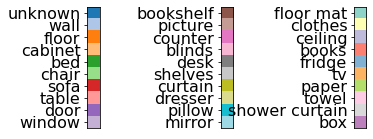

In [6]:
from dataloaders import get_label_colors

font = {'size'   : 16}

matplotlib.rc('font', **font)

#Class colors for reference
names = [x.replace('_', ' ') for x in val.loader.class_names]
colors = np.expand_dims(get_label_colors(cfg), 0)

display_labels(colors[:, :len(names), :], names)

## Bounding Boxes

Use the config setting to load bboxes instead of segmentation

In [7]:
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ANNOTATION_TYPE', 'bbox',
                     'DATASET.NO_TRANSFORMS', True,
                     'TRAIN.BATCH_SIZE', 1])

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Using RGB-D input


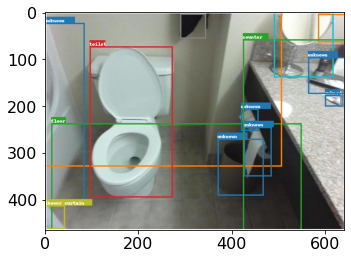

In [8]:
from dataloaders.plots import plot_bboxes

val = make_dataset(cfg, split='val')
dataloader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)

for ii, sample in enumerate(dataloader):
    mosaic = plot_bboxes(sample["image"], sample["label"], names=names, fname=None)
    plt.figure()
    plt.imshow(mosaic.astype(np.uint8))
    plt.show()

    break


## Pixel Intensity Histograms

In [9]:
from dataloaders.utils import sample_distribution

In [10]:
def plot_distribution(a_list, bins, percent=False):
    ax = plt.figure()
    bin_middle = np.array([(bins[x] + bins[x + 1]) / 2.0 for x in range(len(bins) - 1)])
    for a in a_list:
        n = np.histogram(a, bins=bins)[0]
        if percent:
            n = n / np.sum(n)
        # y = scipy.stats.norm.pdf(b, 0, 1)
        plt.plot(bin_middle[np.nonzero(n)], n[np.nonzero(n)])

    return ax

In [11]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.GT_MODE', 'gtFine',
            'DATASET.CITYSCAPES.TRAIN_SET', 'train']
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_train = sample_distribution(make_dataset(cfg, split='train'), n=100)

loading annotations into memory...


2it [00:00, 12.06it/s]

Done (t=0.27s)
creating index...
index created!
Using RGB-D input


100it [00:09, 10.55it/s]


### RGB

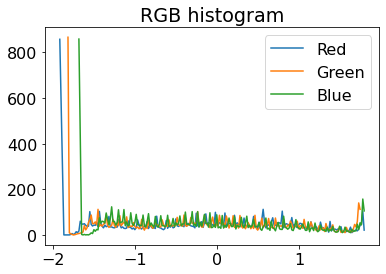

In [12]:
#bin = np.linspace(0, 255)
start = dist_train['mean'][0] - 2*dist_train['std'][0]
end = dist_train['mean'][0] + 2*dist_train['std'][0]
bins = np.linspace(start,end, num=256)

plot_distribution([dist_train['samples'][:, 0],
                  dist_train['samples'][:, 1],
                  dist_train['samples'][:, 2]], bins)
plt.title("RGB histogram")
plt.legend(["Red", "Green", "Blue"])
plt.show()

In [13]:
dist_train

{'mean': array([-1.85237957e-01, -2.07450955e-01, -2.02995616e-01,  2.04756791e-04]),
 'std': array([1.06091475, 1.0423202 , 0.99850719, 0.94354055]),
 'max': array([1.79553902, 1.74021351, 1.78819442, 4.89505529]),
 'median': array([-0.11422116, -0.22754866, -0.29513887,  0.08558393]),
 'samples': array([[-0.55157077, -0.59039843, -0.59470314,  0.89949447],
        [-1.92193317, -1.81850529, -1.68402779, -1.29559743],
        [-1.92193317, -1.81850529, -1.68402779, -1.29559743],
        ...,
        [ 1.47481596,  1.26571763,  1.2026825 , -0.13639164],
        [-0.02675111,  0.02365512,  0.07250828,  0.38155144],
        [ 0.01698385, -0.45084083, -0.63555276,  0.50487119]])}

### Measured Depth

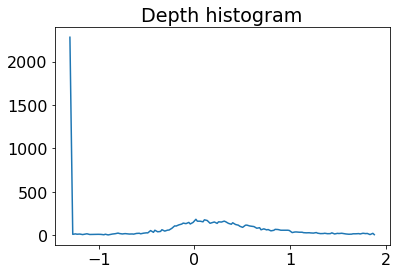

In [14]:
#bin = np.linspace(0, 255)
start = dist_train['mean'][3] - 2*dist_train['std'][3]
end = dist_train['mean'][3] + 2*dist_train['std'][3]
bins = np.linspace(start,end, num=256)

plot_distribution([dist_train['samples'][:, 3:]], bins)
plt.title("Depth histogram")
plt.show()

In [15]:
print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_train['mean'], 
                                         dist_train['std']))

sunrgbd mean: [-1.85237957e-01 -2.07450955e-01 -2.02995616e-01  2.04756791e-04] 
 	 std: [1.06091475 1.0423202  0.99850719 0.94354055]


### Synthetic Depth

loading annotations into memory...


0it [00:00, ?it/s]

Done (t=0.24s)
creating index...
index created!
Using RGB-D input


100it [00:10,  9.56it/s]


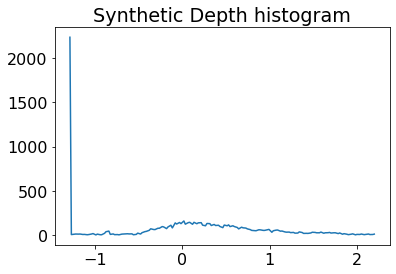

sunrgbd mean: [-0.2054304  -0.21816759 -0.17884665  0.09887784] 
 	 std: [1.10820249 1.08561141 1.02591166 1.05578943]


In [16]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'VNL_Monocular']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_synth = sample_distribution(make_dataset(cfg, split='train'), n=100)

#bin = np.linspace(0, 255)
start = dist_synth['mean'][3] - 2*dist_synth['std'][3]
end = dist_synth['mean'][3] + 2*dist_synth['std'][3]
bins = np.linspace(start,end, num=256)

plot_distribution([dist_synth['samples'][:, 3:]], bins)
plt.title("Synthetic Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_synth['mean'], 
                                         dist_synth['std']))

### Completed Depth

loading annotations into memory...


1it [00:00,  8.59it/s]

Done (t=0.22s)
creating index...
index created!
Using RGB-D input


100it [00:09, 10.52it/s]


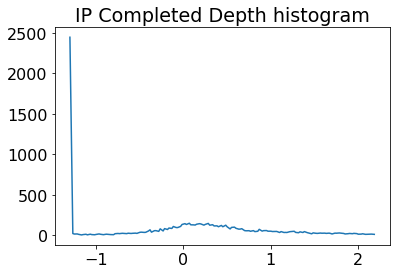

sunrgbd mean: [-0.33805668 -0.32867348 -0.32010891  0.06789745] 
 	 std: [1.10162071 1.07371659 1.01132705 1.06504022]


In [17]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'completed_depth']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_lidar = sample_distribution(make_dataset(cfg, split='train'), n=100)

#bin = np.linspace(0, 255)
start = dist_lidar['mean'][3] - 2*dist_lidar['std'][3]
end = dist_lidar['mean'][3] + 2*dist_lidar['std'][3]
bins = np.linspace(start,end, num=256)

plot_distribution([dist_lidar['samples'][:, 3:]], bins)
plt.title("IP Completed Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_lidar['mean'], 
                                         dist_lidar['std']))

### HHA

In [18]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'HHA',
           'DATASET.MODE', 'RGB_HHA']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_hha = sample_distribution(make_dataset(cfg, split='train'), n=100)

#bin = np.linspace(0, 255)
start = dist_hha['mean'][3] - 2*dist_hha['std'][3]
end = dist_hha['mean'][3] + 2*dist_hha['std'][3]
bins = np.linspace(start,end, num=256)

plot_distribution([dist_hha['samples'][:, 3], dist_hha['samples'][:, 4], dist_hha['samples'][:, 5]], bins)
plt.title("HHA histogram")
plt.legend(["Horizontal disparity", "Height above ground", "Angle of surface normal"])
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_hha['mean'], 
                                         dist_hha['std']))

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


NotImplementedError: HHA normalization factors not implemented for SUNRGBD